In [1]:
from PIL import Image
from pathlib import Path
from time import time
from skimage.transform import resize, rescale
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
RESOLUTION = 10             # Orginal raster resolution
NO_GO = 50                  # No go pixel value
OBS_SIZE = 112              # Observation width and height
LOCAL_REGIONAL_RATIO = 6/3  # The resolution ratio of local and regional observations
LOCAL_NATIONAL_RATIO = 6    # The resolution ratio of local and national observations

path = Path('./cost_surfaces/10km_112nat_336reg_672loc/ras_10km_resampled_071323_WGS84_PIL.tif') # old raster
#path = Path('./cost_surfaces/ras_10km_01252024_WGS84_PIL/ras_10km_01252024_WGS84_PIL.tif') # new raster

(492, 2355)
inf
-1.0


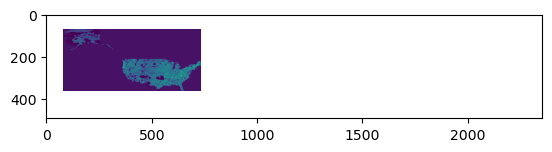

In [3]:
img = Image.open(path)
arr = np.array(img)
print(arr.shape)
print(arr.max())
print(arr.min())
plt.imshow(arr)
plt.show()

In [4]:
def nomrmalize(arr, high=1, low=0):
    norm = (high-low)*(arr - arr.min())/(arr.max() - arr.min()) + low
    return norm

## Process Continental US

Min pixel value: 0.0
Max pixel value: 50.0
pad width: 136


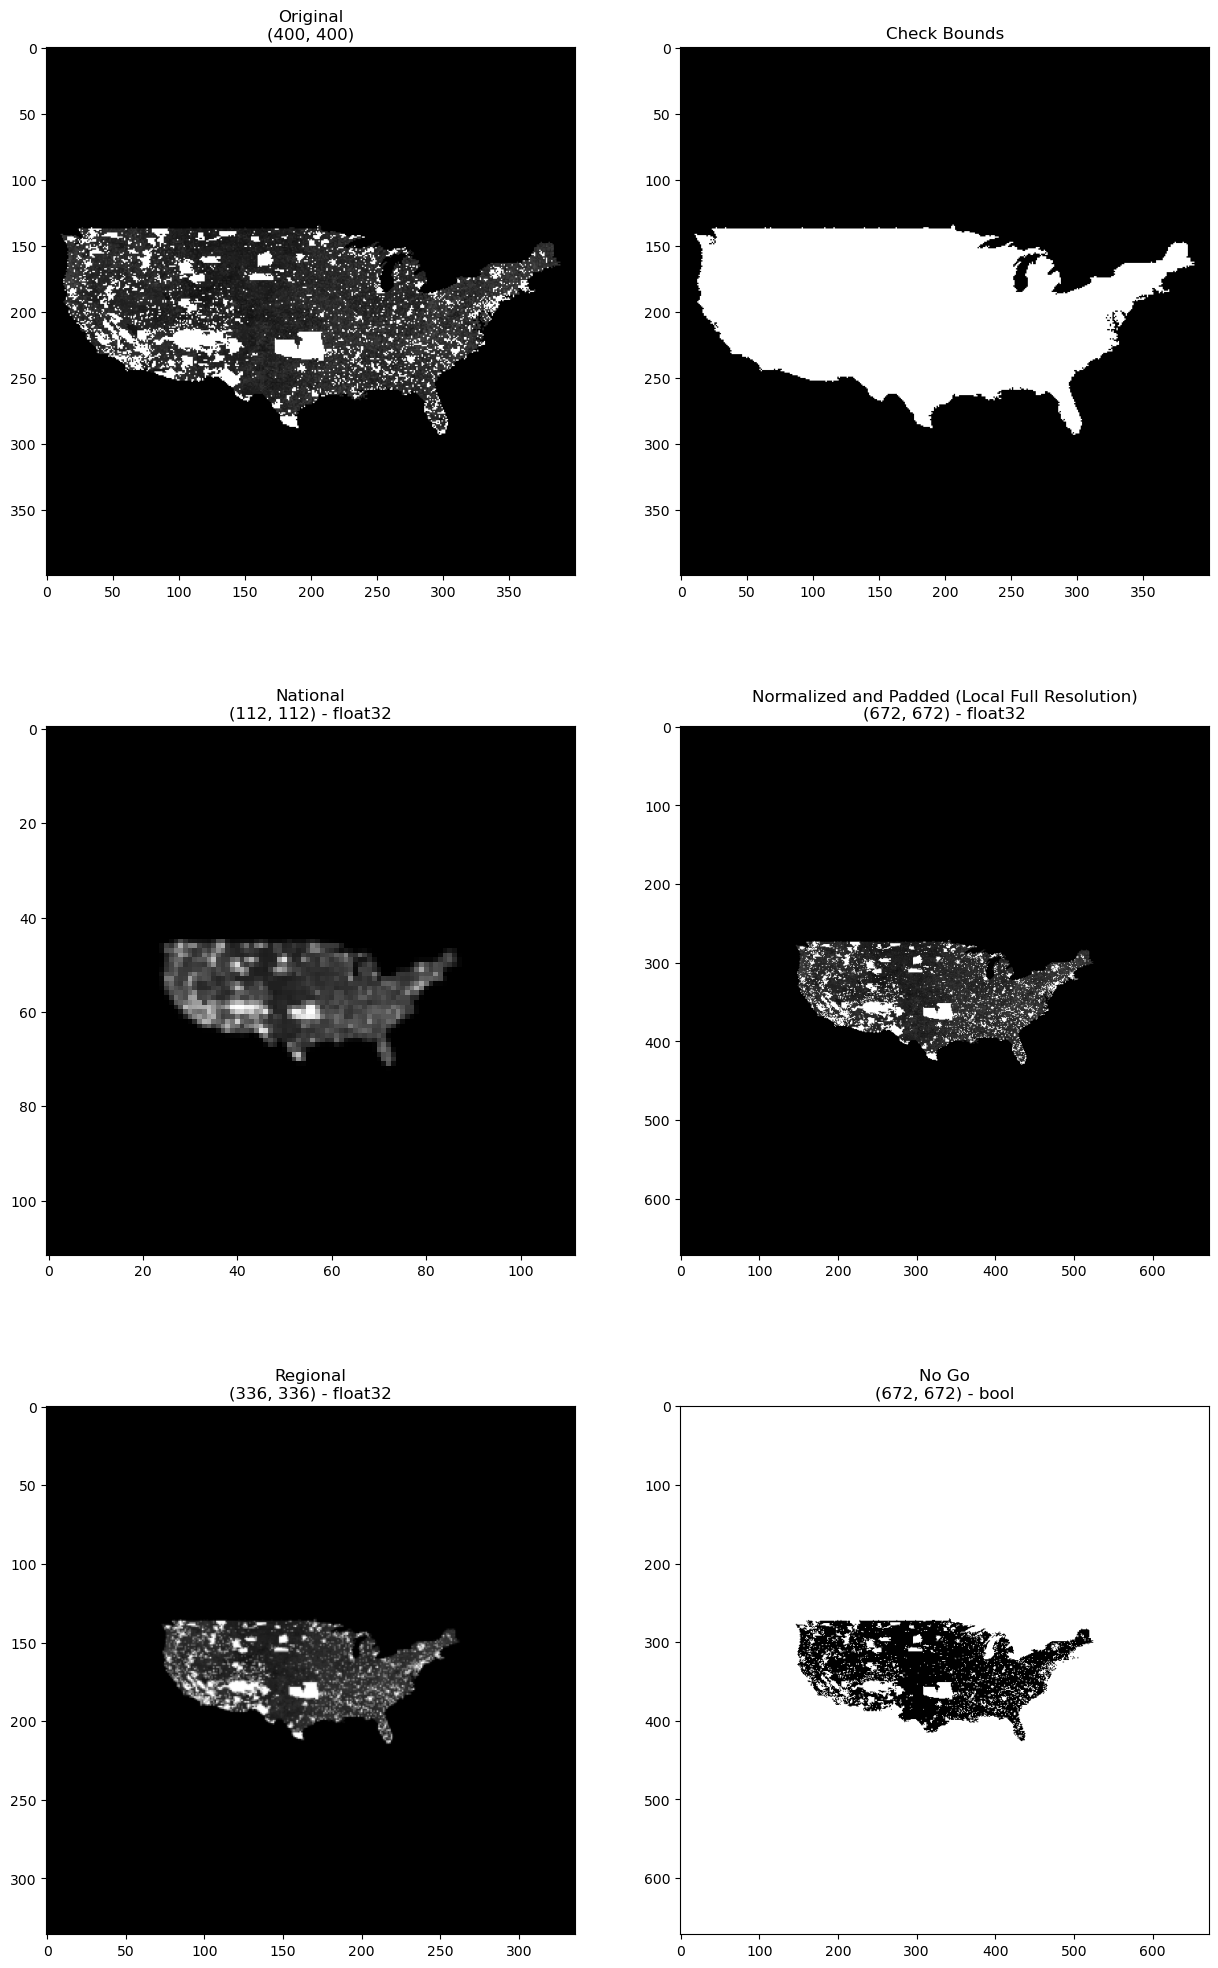

In [5]:
if RESOLUTION == 10:
    clip = arr[75:475, 350:750].copy() # Coordinates for 10km clip

    check_bounds = clip.copy()
    
    # Set edge of raster to 0
    clip[clip==np.inf] = 0

    check_bounds = clip.copy()
    check_bounds[check_bounds<0] = 1
    check_bounds[check_bounds>0] = 1

    no_go = clip.copy()
    no_go[no_go<0] = 0
    no_go[no_go>0] = 1
    no_go = np.invert(no_go.astype(bool))

    # Set no go area pixel value
    clip[clip==-1] = NO_GO

    print('Min pixel value:', clip.min())
    print('Max pixel value:', clip.max())

    # Padd full resolution to multiple of ResNet expected input (112x112)
    pad_width = int((OBS_SIZE*LOCAL_NATIONAL_RATIO - clip.shape[0])/2)
    print('pad width: {}'.format(pad_width))

    # Pad
    padded = np.pad(clip.copy(), pad_width=pad_width, constant_values=0)
    no_go = np.pad(no_go, pad_width=pad_width, constant_values=1)
    
    # Normalize
    norm = nomrmalize(padded)

    # Local is a copy of full resolution
    local = norm.copy()

    rlr = LOCAL_REGIONAL_RATIO
    regional_shape = local.shape[0]/rlr, local.shape[1]/rlr 

    regional = resize(norm.copy(),regional_shape)

    # National observation
    national = resize(norm.copy(), (OBS_SIZE, OBS_SIZE))


    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,25))
    ax[0,0].imshow(clip, cmap='gray')
    ax[0,0].set_title('Original\n{}'.format(clip.shape))

    ax[0,1].imshow(check_bounds, cmap='gray')
    ax[0,1].set_title('Check Bounds')

    ax[1,0].set_title('National\n{} - {}'.format(national.shape, national.dtype))
    ax[1,0].imshow(national, cmap='gray')

    ax[1,1].imshow(norm, cmap='gray')
    ax[1,1].set_title('Normalized and Padded (Local Full Resolution)\n{} - {}'.format(local.shape, local.dtype))

    ax[2,0].imshow(regional, cmap='gray')
    ax[2,0].set_title('Regional\n{} - {}'.format(regional.shape, regional.dtype))

    ax[2,1].imshow(no_go, cmap='gray')
    ax[2,1].set_title('No Go\n{} - {}'.format(no_go.shape, no_go.dtype))

    plt.show()

In [15]:
def validate_padding_size(raster, obs_size):
    """
    Ensure there is enough padding on edge of raster to avoid indexing errors during env simulation
    """
    idx = int(obs_size/2) # represents first indice along edge where non-zero values cannot be present

    top = raster[:idx, :].sum()
    right = raster[:, -idx:].sum()
    bottom = raster[-idx:, :].sum()
    left = raster[:, :idx].sum()

    if top + right + bottom + left > 0:
        raise ValueError('Raster contains invalid edge pixels top: {} - right: {} - bottom,: {} - left: {}'.format(top, right, bottom, left))

In [18]:
validate_padding_size(regional, OBS_SIZE)
validate_padding_size(local, OBS_SIZE)

In [22]:
def save_rasters(dir_path, national, regional, local, no_go, meta):

    res = meta['resolution']
    nat_size = national.shape[0]
    reg_size = regional.shape[0]
    loc_size = local.shape[0]

    name = '{}km_{}nat_{}reg_{}loc'.format(res, nat_size, reg_size, loc_size)
    raster_dir = Path(dir_path).joinpath(name)
    os.mkdir(raster_dir)

    national_path = raster_dir.joinpath('national.npy')
    regional_path = raster_dir.joinpath('regional.npy')
    local_path = raster_dir.joinpath('local.npy')
    no_go_path = raster_dir.joinpath('no_go.npy')
    
    np.save(national_path, national)
    np.save(regional_path, regional)
    np.save(local_path, local)
    np.save(no_go_path, no_go)

In [20]:
save_rasters(
    '/home/ben/raster/cost_surfaces/',
    national,
    regional,
    local,
    no_go,
    {'resolution': RESOLUTION}
)

## Process Alaska

Min pixel value: 0.0
Max pixel value: 50.0
pad width y: 211
pad width x: 161


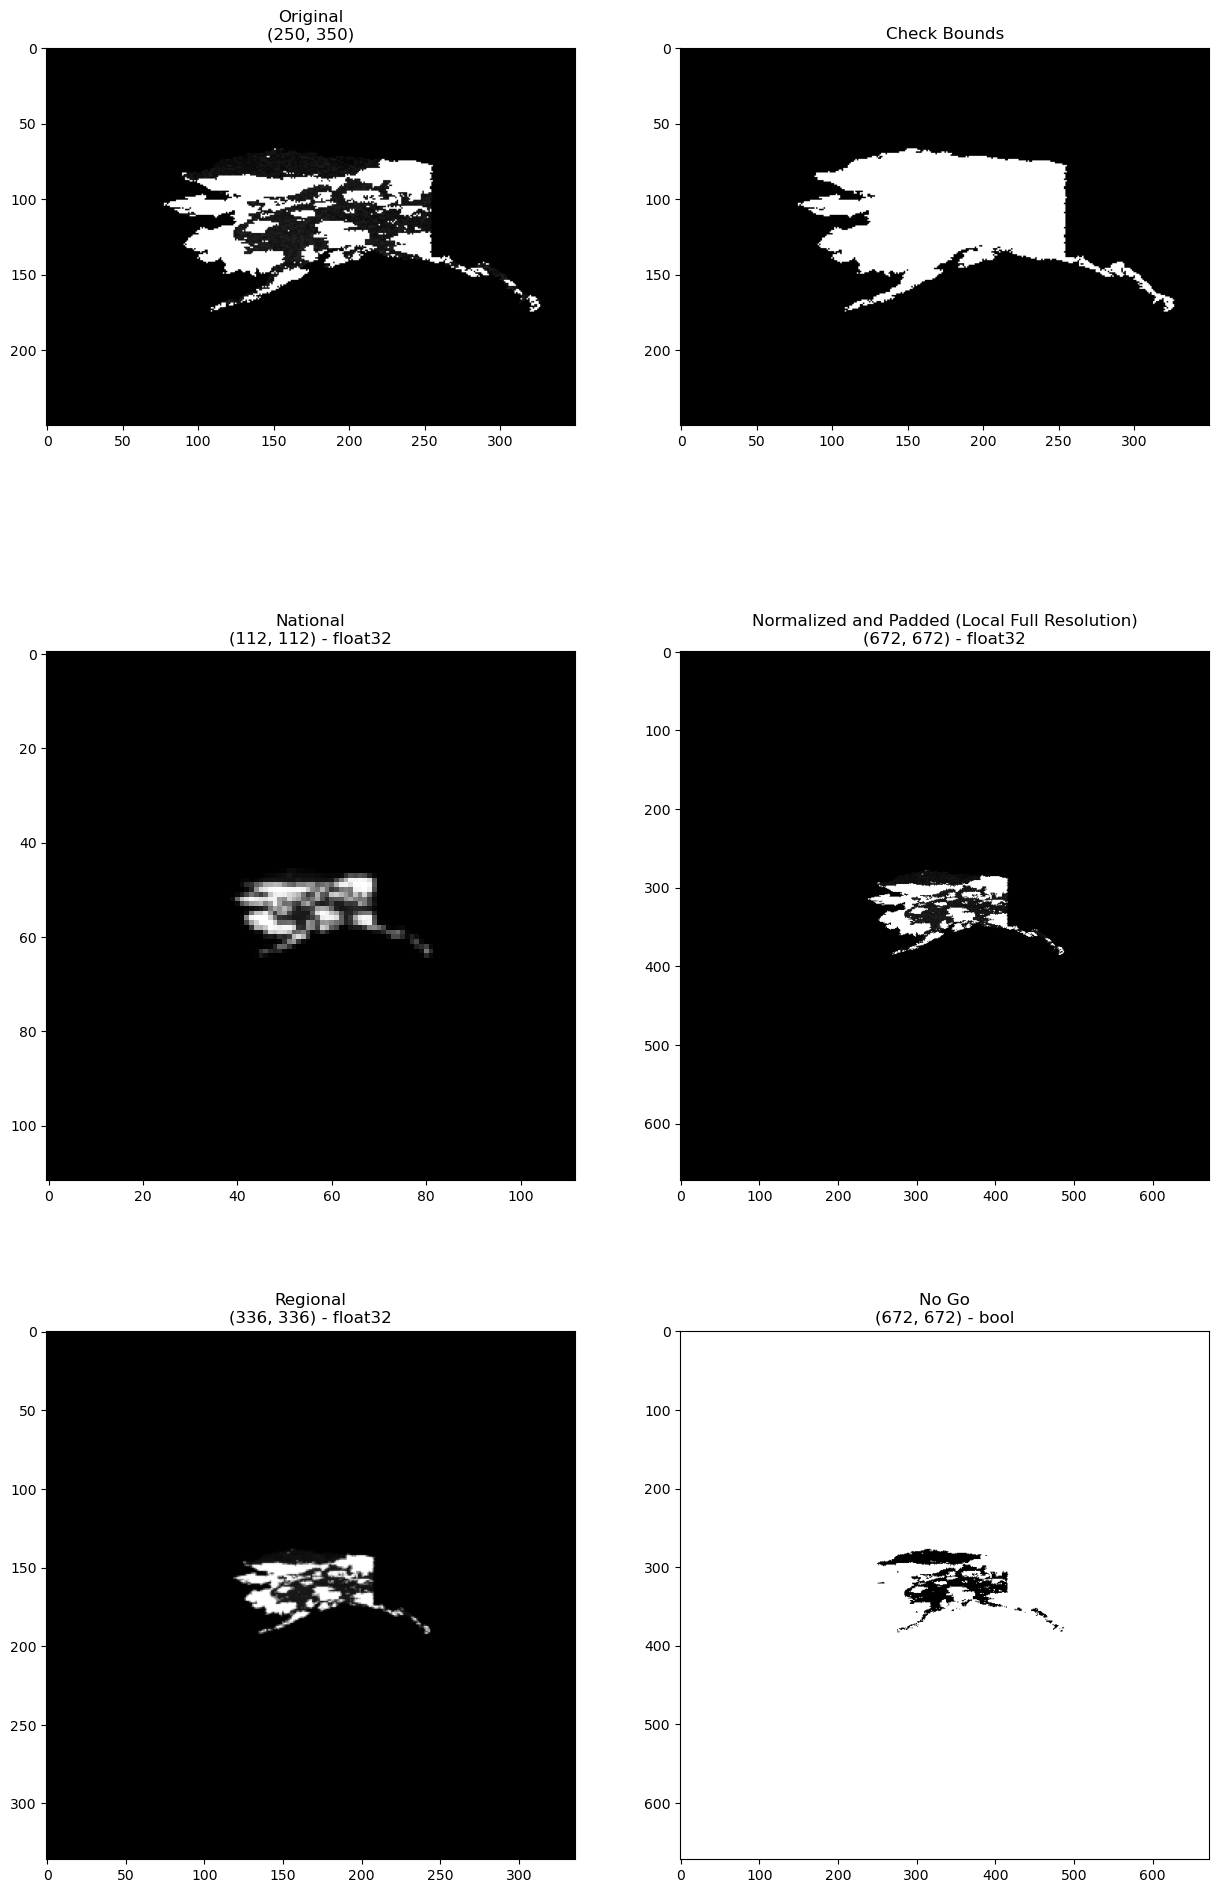

In [16]:
if RESOLUTION == 10:
    clip = arr[0:250, 0:350].copy() # Coordinates for 10km clip

    check_bounds = clip.copy()
    
    # Set edge of raster to 0
    clip[clip==np.inf] = 0

    check_bounds = clip.copy()
    check_bounds[check_bounds<0] = 1
    check_bounds[check_bounds>0] = 1

    no_go = clip.copy()
    no_go[no_go<0] = 0
    no_go[no_go>0] = 1
    no_go = np.invert(no_go.astype(bool))

    # Set no go area pixel value
    clip[clip==-1] = NO_GO

    print('Min pixel value:', clip.min())
    print('Max pixel value:', clip.max())

    # Padd full resolution to multiple of ResNet expected input (112x112)
    pad_width_y = int((OBS_SIZE*LOCAL_NATIONAL_RATIO - clip.shape[0])/2)
    pad_width_x = int((OBS_SIZE*LOCAL_NATIONAL_RATIO - clip.shape[1])/2)

    print('pad width y: {}'.format(pad_width_y))
    print('pad width x: {}'.format(pad_width_x))
    pad_width = ((pad_width_y, pad_width_y), (pad_width_x, pad_width_x))
    # assert pad_width_y%2 == 0 # Ensure padding can be evenly distributed
    # assert pad_width_x%2 == 0

    # Pad
    padded = np.pad(clip.copy(), pad_width=pad_width, constant_values=0)
    no_go = np.pad(no_go, pad_width=pad_width, constant_values=1)
    
    # Normalize
    norm = nomrmalize(padded)

    # Local is a copy of full resolution
    local = norm.copy()

    rlr = LOCAL_REGIONAL_RATIO
    regional_shape = local.shape[0]/rlr, local.shape[1]/rlr 

    regional = resize(norm.copy(),regional_shape)

    # National observation
    national = resize(norm.copy(), (OBS_SIZE, OBS_SIZE))


    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,25))
    ax[0,0].imshow(clip, cmap='gray')
    ax[0,0].set_title('Original\n{}'.format(clip.shape))

    ax[0,1].imshow(check_bounds, cmap='gray')
    ax[0,1].set_title('Check Bounds')

    ax[1,0].set_title('National\n{} - {}'.format(national.shape, national.dtype))
    ax[1,0].imshow(national, cmap='gray')

    ax[1,1].imshow(norm, cmap='gray')
    ax[1,1].set_title('Normalized and Padded (Local Full Resolution)\n{} - {}'.format(local.shape, local.dtype))

    ax[2,0].imshow(regional, cmap='gray')
    ax[2,0].set_title('Regional\n{} - {}'.format(regional.shape, regional.dtype))

    ax[2,1].imshow(no_go, cmap='gray')
    ax[2,1].set_title('No Go\n{} - {}'.format(no_go.shape, no_go.dtype))

    plt.show()

In [19]:
def validate_padding_size(raster, obs_size):
    """
    Ensure there is enough padding on edge of raster to avoid indexing errors during env simulation
    """
    idx = int(obs_size/2) # represents first indice along edge where non-zero values cannot be present
    print(idx)

    top = raster[:idx, :].sum()
    right = raster[:, -idx:].sum()
    bottom = raster[-idx:, :].sum()
    left = raster[:, :idx].sum()

    if top + right + bottom + left > 0:
        raise ValueError('Raster contains invalid edge pixels top: {} - right: {} - bottom,: {} - left: {}'.format(top, right, bottom, left))

In [20]:
validate_padding_size(regional, OBS_SIZE)
validate_padding_size(local, OBS_SIZE)

56
56


In [24]:
def save_rasters(dir_path, national, regional, local, no_go, meta):

    res = meta['resolution']
    area = meta['area']
    nat_size = national.shape[0]
    reg_size = regional.shape[0]
    loc_size = local.shape[0]

    name = '{}_{}km_{}nat_{}reg_{}loc'.format(area, res, nat_size, reg_size, loc_size)
    raster_dir = Path(dir_path).joinpath(name)
    os.mkdir(raster_dir)

    national_path = raster_dir.joinpath('national.npy')
    regional_path = raster_dir.joinpath('regional.npy')
    local_path = raster_dir.joinpath('local.npy')
    no_go_path = raster_dir.joinpath('no_go.npy')
    
    np.save(national_path, national)
    np.save(regional_path, regional)
    np.save(local_path, local)
    np.save(no_go_path, no_go)

In [25]:
save_rasters(
    './cost_surfaces/',
    national,
    regional,
    local,
    no_go,
    {'resolution': RESOLUTION, 'area':'AL'}
)

In [27]:
'AL' in 'gym/grid/cost_surfaces/AL_10km_112nat_336reg_672loc'

True

## OLD CODE BELOW

(3310, 7714)
(9664, 9664)


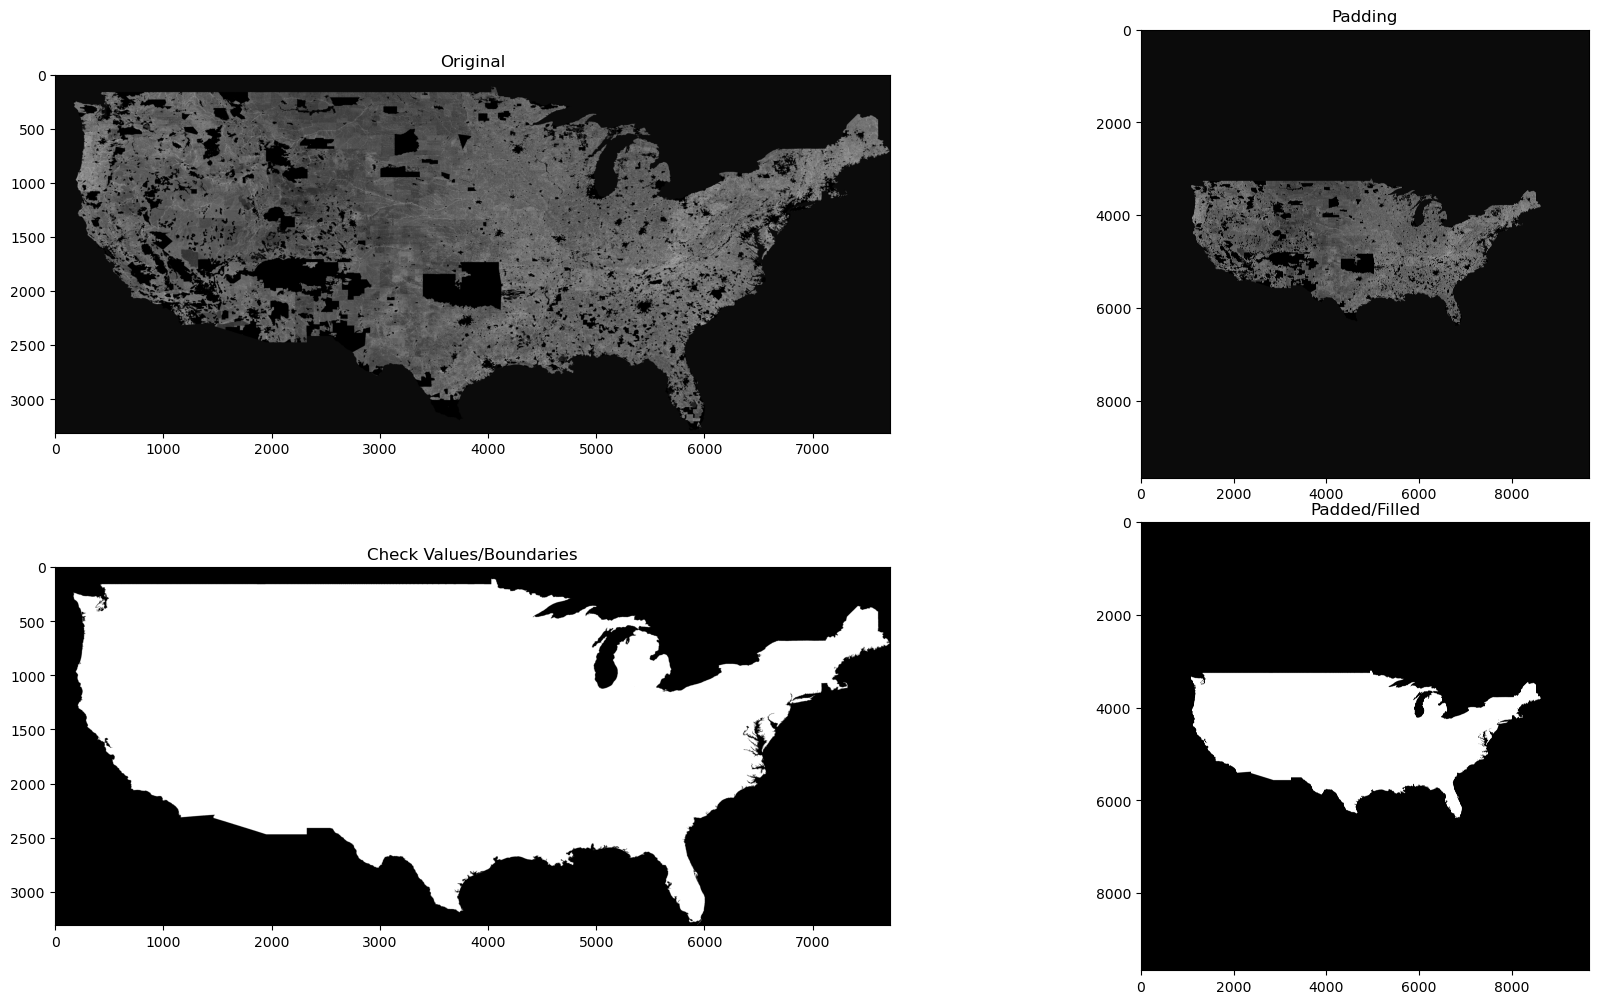

In [10]:
clip = arr[2750:, 5500:] # Coordinates for 1km clip
clip = arr[2750:, 5500:] # Coordinates for 10km clip

print(clip.shape)
check_bounds = clip.copy()
check_bounds[check_bounds>0] = 255
check_bounds[check_bounds==-1] = 255

padded = clip.copy()
padded = np.pad(padded, pad_width=((900+2202, 1050+2202), (900, 1050)), constant_values=(0,0))

padded_filled = padded.copy()
padded_filled[padded_filled>0] = 255
padded_filled[padded_filled==-1] = 255
print(padded.shape)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,10))
fig.tight_layout()
ax[0,0].set_title('Original')
ax[0,0].imshow(clip, cmap='gray')

ax[1,0].set_title('Check Values/Boundaries')
ax[1,0].imshow(check_bounds, cmap='gray')

ax[0,1].set_title('Padding')
ax[0,1].imshow(padded, cmap='gray')

ax[1,1].set_title('Padded/Filled')
ax[1,1].imshow(padded_filled, cmap='gray')

plt.show()

In [12]:
# Add some padding to the raster
cost_surface = padded.copy()

# Save the final cost surface
np.save('/home/ben/raster/cost_surface/padded_square_1km.npy', cost_surface)

In [9]:
test_surface = padded.copy()
test_surface[test_surface==-1]=255

In [19]:
size = 224*2

start = time()
resized = resize(test_surface, (size,size))
end = time()
print('{:.4f}'.format(end-start))
print(resized.shape)


start = time()
rescaled = rescale(test_surface, size/test_surface.shape[0])
end = time()
print('{:.4f}'.format(end-start))
print(resized.shape)

2.9350
(448, 448)
3.0957
(448, 448)


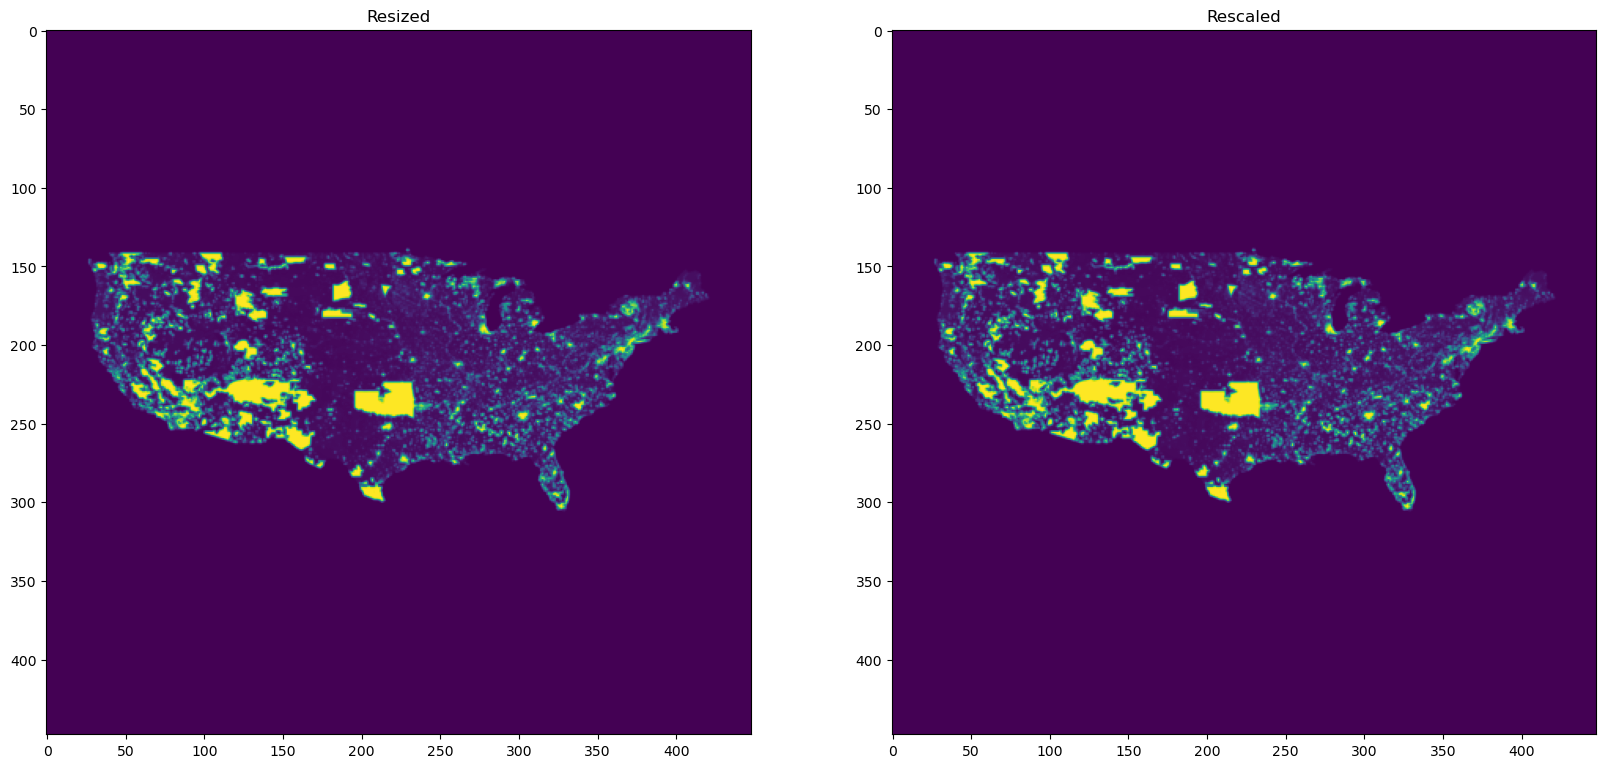

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].set_title('Resized')
ax[0].imshow(resized)
ax[1].set_title('Rescaled')
ax[1].imshow(rescaled)
plt.show()
